In [ ]:
%pip install -U azure-ai-ml>=1.10
%pip install -U 'azureml-rag[azure,cognitive_search]>=0.2.2'

In [ ]:
%%writefile config.json
{
    "subscription_id": "<subscription_id>",
    "resource_group": "<resource_group_name>",
    "workspace_name": "<workspace_name>"
}

In [ ]:
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azure.ai.ml import MLClient

try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

ml_client = MLClient.from_config(credential=credential)

Define the `crack_and_chunk_with_doc_intel` Component which can be used in place of the `crack_and_chunk` Component in Vector Index creation Pipelines.

In [ ]:
from pathlib import Path
from azure.ai.ml import Input, Output, command
from azure.ai.ml.entities import BuildContext, Environment

llm_rag_embeddings_doc_intel_environment = Environment(
    name="llm_rag_embeddings_doc_intel",
    description="AzureML RAGs base crack_and_chunk environment with azure-ai-formrecognizer installed.",
    build=BuildContext(path=Path.cwd() / "doc_intel_env"),
)

crack_and_chunk_with_doc_intel_component = command(
    version="0.0.1",
    name="crack_and_chunk_with_doc_intel",
    display_name="Crack and Chunk Data leveraging Azure AI Document Intelligence for PDFs",
    description="""Creates chunks from source data leveraging Azure AI Document Intelligence for PDFs.

    Supported formats: md, txt, html/htm, pdf, ppt(x), doc(x), xls(x), py""",
    inputs={
        # Input AzureML Data
        "input_data": Input(type="uri_folder", mode="rw_mount"),
        # Files to handle from source
        "input_glob": Input(
            type="string",
            default="**/*",
            description="Limit files opened from `input_data`, defaults to '**/*'",
        ),
        "allowed_extensions": Input(
            type="string",
            optional=True,
            description="Comma separated list of extensions to include, if not provided the default list of supported extensions will be used. e.g. '.md,.txt,.html,.py,.pdf'",
        ),
        # Chunking options
        "chunk_size": Input(
            type="integer",
            default=768,
            description="Maximum number of tokens per chunk.",
        ),
        "chunk_overlap": Input(
            type="integer",
            default=0,
            description="Number of tokens to overlap between chunks.",
        ),
        "use_rcts": Input(
            type="boolean",
            default=True,
            description="Use langchain RecursiveTextSplitter to split chunks.",
        ),
        # Augmentation options
        "data_source_url": Input(
            type="string",
            optional=True,
            description="Base URL to join with file paths to create full source file URL for chunk metadata.",
        ),
        "document_path_replacement_regex": Input(
            type="string",
            optional=True,
            description="A JSON string with two fields, 'match_pattern' and 'replacement_pattern' to be used with re.sub on the source url. e.g. '{\"match_pattern\": \"(.*)/articles/(.*)\", \"replacement_pattern\": \"\\1/\\2\"}' would remove '/articles' from the middle of the url.",
        ),
        "doc_intel_connection_id": Input(
            type="string",
            description="AzureML Connection ID for Custom Workspace Connection containing the `endpoint` key and `api_key` secret for an Azure AI Document Intelligence Service.",
        ),
        "use_layout": Input(
            type="boolean",
            default=False,
            description="Use 'prebuilt-layout' model from Azure AI Document Intelligence, more expensive and slower but maintains more structure from original doc.",
        ),
    },
    outputs={
        "output_chunks": Output(type="uri_folder"),
    },
    code=Path.cwd() / "crack_and_chunk_with_doc_intel",
    command="""python crack_and_chunk.py\
    --input_data ${{inputs.input_data}}\
    --input_glob '${{inputs.input_glob}}'\
    $[[--allowed_extensions ${{inputs.allowed_extensions}}]]\
    --output_chunks ${{outputs.output_chunks}}\
    --chunk_size ${{inputs.chunk_size}}\
    --chunk_overlap ${{inputs.chunk_overlap}}\
    --use_rcts ${{inputs.use_rcts}}\
    $[[--data_source_url ${{inputs.data_source_url}}]]\
    $[[--document_path_replacement_regex '${{inputs.document_path_replacement_regex}}']]\
    --doc_intel_connection_id '${{inputs.doc_intel_connection_id}}'\
    --use_layout ${{inputs.use_layout}}\
    """,
    environment=llm_rag_embeddings_doc_intel_environment,
)

Define pipeline using the custom `crack_and_chunk_with_doc_intel` Component along with the AzureML provided Components to embed and index your data.

In [ ]:
ml_registry = MLClient(credential=ml_client._credential, registry_name="azureml")

# Reads input folder of files containing chunks and their metadata as batches, in parallel, and generates embeddings for each chunk. Output format is produced and loaded by `azureml.rag.embeddings.EmbeddingContainer`.
generate_embeddings_component = ml_registry.components.get(
    "llm_rag_generate_embeddings", label="latest"
)
# Reads an input folder produced by `azureml.rag.embeddings.EmbeddingsContainer.save()` and pushes all documents (chunk, metadata, embedding_vector) into an Azure Cognitive Search index. Writes an MLIndex yaml detailing the index and embeddings model information.
update_acs_index_component = ml_registry.components.get(
    "llm_rag_update_acs_index", label="latest"
)
# Takes a uri to a storage location where an MLIndex yaml is stored and registers it as an MLIndex Data asset in the AzureML Workspace.
register_mlindex_asset_component = ml_registry.components.get(
    "llm_rag_register_mlindex_asset", label="latest"
)

In [ ]:
from azure.ai.ml import Input, Output
from azure.ai.ml.dsl import pipeline
from azure.ai.ml.entities._job.pipeline._io import PipelineInput


def use_automatic_compute(
    component, instance_count=1, instance_type="Standard_D4as_v4"
):
    component.set_resources(
        instance_count=instance_count,
        instance_type=instance_type,
        properties={"compute_specification": {"automatic": True}},
    )
    return component


def optional_pipeline_input_provided(input: PipelineInput):
    return input._data is not None


@pipeline(default_compute="serverless")
def uri_to_acs(
    input_data: Input,
    doc_intel_connection_id: str,
    embeddings_model: str,
    acs_config: str,
    acs_connection_id: str,
    asset_name: str,
    chunk_size: int = 512,
    data_source_glob: str = None,
    data_source_url: str = None,
    document_path_replacement_regex: str = None,
    use_layout: bool = False,
    aoai_connection_id: str = None,
    embeddings_container: Input = None,
):
    crack_and_chunk = crack_and_chunk_with_doc_intel_component(
        input_data=input_data,
        input_glob=data_source_glob,
        chunk_size=chunk_size,
        use_rcts=True,
        data_source_url=data_source_url,
        document_path_replacement_regex=document_path_replacement_regex,
        doc_intel_connection_id=doc_intel_connection_id,
        use_layout=use_layout,
    )
    use_automatic_compute(crack_and_chunk)

    generate_embeddings = generate_embeddings_component(
        chunks_source=crack_and_chunk.outputs.output_chunks,
        embeddings_container=embeddings_container,
        embeddings_model=embeddings_model,
    )

    use_automatic_compute(generate_embeddings)
    if optional_pipeline_input_provided(aoai_connection_id):
        generate_embeddings.environment_variables[
            "AZUREML_WORKSPACE_CONNECTION_ID_AOAI"
        ] = aoai_connection_id
    if optional_pipeline_input_provided(embeddings_container):
        # If provided, previous_embeddings is expected to be a URI to an 'embeddings container' folder.
        # Each folder under this folder is generated by a `generate_embeddings_component` run and can be reused for subsequent embeddings runs.
        generate_embeddings.outputs.embeddings = Output(
            type="uri_folder", path=f"{embeddings_container.path}/{{name}}"
        )

    update_acs_index = update_acs_index_component(
        embeddings=generate_embeddings.outputs.embeddings,
        acs_config=acs_config,
    )
    use_automatic_compute(update_acs_index)
    if optional_pipeline_input_provided(acs_connection_id):
        update_acs_index.environment_variables[
            "AZUREML_WORKSPACE_CONNECTION_ID_ACS"
        ] = acs_connection_id

    register_mlindex = register_mlindex_asset_component(
        storage_uri=update_acs_index.outputs.index,
        asset_name=asset_name,
    )
    use_automatic_compute(register_mlindex)
    return {
        "mlindex_asset_uri": update_acs_index.outputs.index,
        "mlindex_asset_id": register_mlindex.outputs.asset_id,
    }

Get the connections to Azure OpenAI (for embeddings with `text-embedding-ada-002`) and Azure Cognitive Search.

In [ ]:
aoai_connection = ml_client.connections.get("azureml-rag-oai")
acs_connection = ml_client.connections.get("azureml-rag-acs")

Create a Custom Connection with details for an Azure AI Document Intelligence Service.
[Setup instructions for Azure AI Document Intelligence]()

Use the Connections UI in an AzureML Workspace, under the Promptflow tab, to create a connection with these fields: 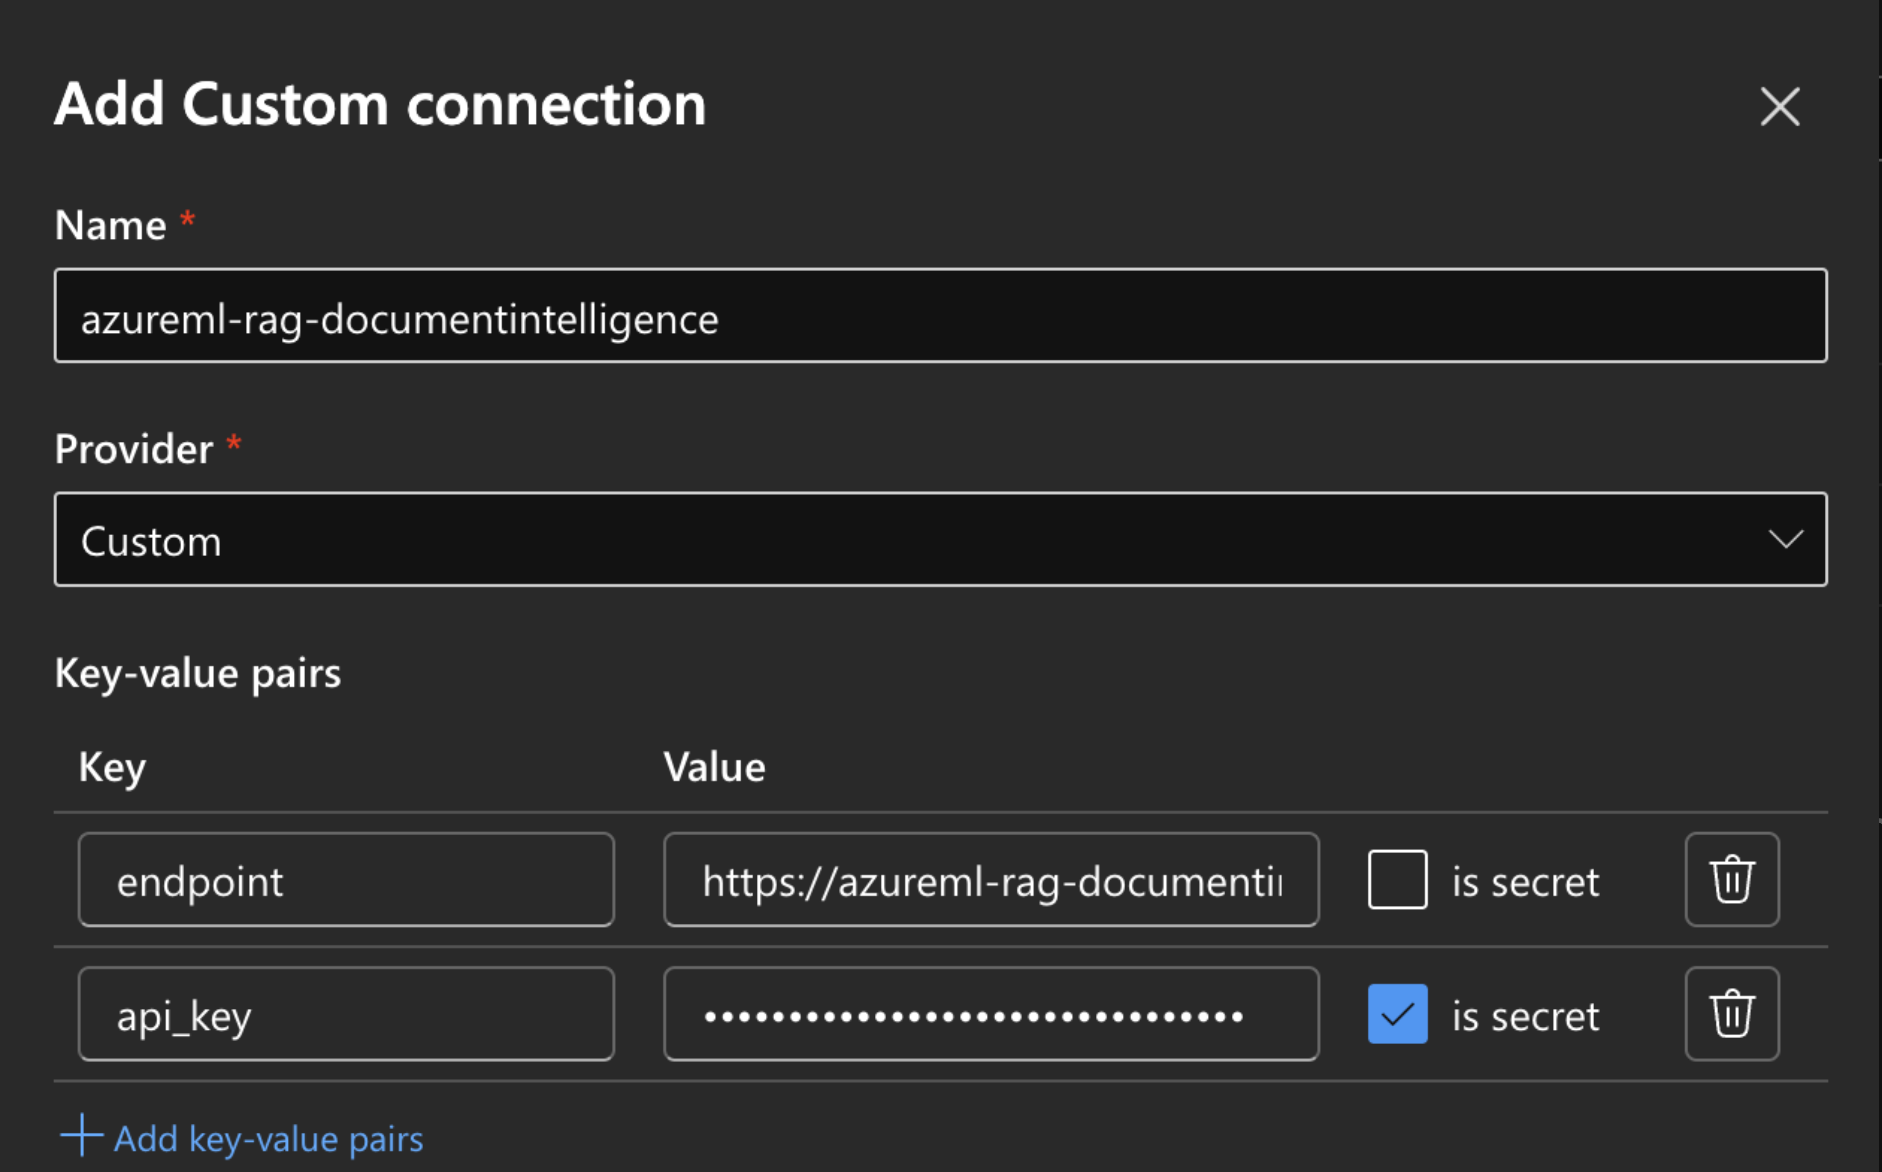

It's not yet supported to create/retrieve Custom Connections using SDK, so you will need to create it using the UI and we'll use string replacement below to get the ID for this custom connection to pass to our pipeline.

In [ ]:
document_intelligence_connection_id = aoai_connection.id.replace(
    "azureml-rag-oai", "azureml-rag-documentintelligence"
)
document_intelligence_connection_id

In [ ]:
import json
from azure.ai.ml import Input

embeddings_model = (
    "azure_open_ai://deployment/text-embedding-ada-002/model/text-embedding-ada-002"
)

data_source = Path.cwd() / "pdfs"
asset_name = f"doc_intel_{embeddings_model.split(':')[0]}_acs"

pipeline_job = uri_to_acs(
    input_data=Input(type="uri_folder", path=str(data_source)),
    data_source_glob="**/*",
    data_source_url=None,
    document_path_replacement_regex=None,
    doc_intel_connection_id=document_intelligence_connection_id,
    use_layout=False,
    embeddings_model=embeddings_model,
    aoai_connection_id=aoai_connection.id,
    embeddings_container=Input(
        type="uri_folder",
        path=f"azureml://datastores/workspaceblobstore/paths/embeddings/{asset_name}",
    ),
    acs_config=json.dumps(
        {
            "index_name": asset_name,
        }
    ),
    acs_connection_id=acs_connection.id,
    asset_name=asset_name,
)
pipeline_job.display_name = asset_name

# Properties for Vector Index UI
pipeline_job.properties["azureml.mlIndexAssetName"] = asset_name
pipeline_job.properties["azureml.mlIndexAssetKind"] = "acs"
pipeline_job.properties["azureml.mlIndexAssetSource"] = "AzureML Data"

In [ ]:
print(f"Submitting pipeline job to experiment: {asset_name}")
running_pipeline_job = ml_client.jobs.create_or_update(
    pipeline_job, experiment_name=asset_name
)

print(f"Submitted run, url: {running_pipeline_job.studio_url}")

In [ ]:
ml_client.jobs.stream(running_pipeline_job.name)

In [ ]:
from azureml.rag.mlindex import MLIndex

question = "What is RAG?"

retriever = MLIndex(
    ml_client.data.get(asset_name, label="latest")
).as_langchain_retriever()
retriever.get_relevant_documents(question)